# **Generative Adversarial Network (GAN): Image Generation**

Train a GAN from scratch on the MNIST handwritten digits dataset to generate realistic digit images. Explore the generator, discriminator, training dynamics, and latent space interpolation.

In [1]:
# --- Import Libraries ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print("Libraries loaded successfully!")

2026-02-14 18:47:19.256488: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-14 18:47:19.257171: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-14 18:47:19.364385: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2026-02-14 18:47:24.010664: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-14 18:47:24.027856: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


TensorFlow Version: 2.20.0
GPU Available: False
Libraries loaded successfully!


2026-02-14 18:47:25.680990: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
# --- Load MNIST Dataset ---
print("=" * 60)
print("DATASET: MNIST HANDWRITTEN DIGITS")
print("=" * 60)

(X_train_full, y_train_full), (X_test_full, y_test_full) = mnist.load_data()

print(f"\nFull Training Set: {X_train_full.shape}")
print(f"Full Test Set: {X_test_full.shape}")
print(f"Pixel Range: [{X_train_full.min()}, {X_train_full.max()}]")
print(f"Data Type: {X_train_full.dtype}")
print(f"Unique Labels: {np.unique(y_train_full)}")

DATASET: MNIST HANDWRITTEN DIGITS


       0/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

 3940352/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

 8159232/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step



Full Training Set: (60000, 28, 28)
Full Test Set: (10000, 28, 28)
Pixel Range: [0, 255]
Data Type: uint8
Unique Labels: [0 1 2 3 4 5 6 7 8 9]


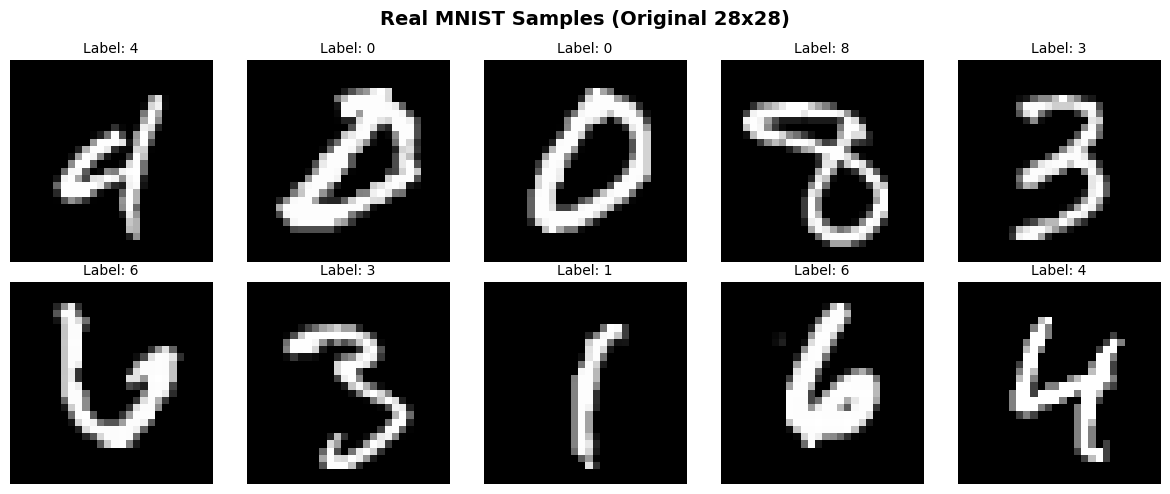

In [3]:
# --- Visualize Real Samples ---
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
np.random.seed(42)
for ax in axes.flat:
    idx = np.random.randint(0, len(X_train_full))
    ax.imshow(X_train_full[idx], cmap='gray')
    ax.set_title(f"Label: {y_train_full[idx]}", fontsize=10)
    ax.axis('off')
plt.suptitle('Real MNIST Samples (Original 28x28)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [4]:
# --- Data Preprocessing ---
print("=" * 60)
print("DATA PREPROCESSING")
print("=" * 60)

TRAIN_SIZE = 5000
LATENT_DIM = 100

# Use a subset for faster CPU training
np.random.seed(42)
train_idx = np.random.choice(len(X_train_full), TRAIN_SIZE, replace=False)
X_train = X_train_full[train_idx]

# Normalize to [-1, 1] range (required for tanh activation in generator)
X_train = (X_train.astype('float32') - 127.5) / 127.5

# Reshape to (N, 28, 28, 1) for compatibility
X_train = X_train.reshape(-1, 28, 28, 1)

print(f"Training Subset: {X_train.shape}")
print(f"Pixel Range: [{X_train.min():.1f}, {X_train.max():.1f}]")
print(f"Latent Dimension: {LATENT_DIM}")
print(f"Data Type: {X_train.dtype}")

DATA PREPROCESSING
Training Subset: (5000, 28, 28, 1)
Pixel Range: [-1.0, 1.0]
Latent Dimension: 100
Data Type: float32


In [5]:
# --- Build Generator Network ---
print("=" * 60)
print("GENERATOR NETWORK")
print("=" * 60)

def build_generator(latent_dim):
    model = models.Sequential(name='Generator')

    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Dense(28 * 28 * 1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))

    return model

generator = build_generator(LATENT_DIM)
generator.summary()

GENERATOR NETWORK


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       803,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,493,520 (5.70 MB)

 Trainable params: 1,489,936 (5.68 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [6]:
# --- Build Discriminator Network ---
print("=" * 60)
print("DISCRIMINATOR NETWORK")
print("=" * 60)

def build_discriminator(img_shape=(28, 28, 1)):
    model = models.Sequential(name='Discriminator')

    model.add(layers.Flatten(input_shape=img_shape))

    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    metrics=['accuracy']
)
discriminator.summary()

DISCRIMINATOR NETWORK


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# --- Build and Compile GAN (Combined Model) ---
print("=" * 60)
print("GAN: COMBINED MODEL")
print("=" * 60)

# Freeze discriminator weights when training generator through GAN
discriminator.trainable = False

gan_input = layers.Input(shape=(LATENT_DIM,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)

gan = models.Model(gan_input, gan_output, name='GAN')
gan.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5)
)

gan.summary()
print(f"\nGenerator Parameters: {generator.count_params():,}")
print(f"Discriminator Parameters: {discriminator.count_params():,}")
print(f"Total GAN Parameters: {gan.count_params():,}")

GAN: COMBINED MODEL


Model: "GAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Generator (Sequential)          │ (None, 28, 28, 1)      │     1,493,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator (Sequential)      │ (None, 1)              │       533,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,027,025 (7.73 MB)

 Trainable params: 1,489,936 (5.68 MB)

 Non-trainable params: 537,089 (2.05 MB)


Generator Parameters: 1,493,520
Discriminator Parameters: 533,505
Total GAN Parameters: 2,027,025


In [8]:
# --- GAN Training Loop ---
print("=" * 60)
print("GAN TRAINING")
print("=" * 60)

EPOCHS = 30
BATCH_SIZE = 128
HALF_BATCH = BATCH_SIZE // 2
NUM_BATCHES = X_train.shape[0] // BATCH_SIZE

# Storage for metrics
d_losses = []
g_losses = []
d_accuracies = []

# Storage for generated images at specific epochs
saved_epochs = [0, 10, 20, 29]
saved_images = {}

# Fixed noise for consistent visualization across epochs
np.random.seed(0)
fixed_noise = np.random.normal(0, 1, (25, LATENT_DIM))

print(f"Training Samples: {X_train.shape[0]}")
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Batches per Epoch: {NUM_BATCHES}")
print()

for epoch in range(EPOCHS):
    epoch_d_loss = []
    epoch_g_loss = []
    epoch_d_acc = []

    for batch in range(NUM_BATCHES):
        # ---- Train Discriminator ----
        # Real images
        idx = np.random.randint(0, X_train.shape[0], HALF_BATCH)
        real_imgs = X_train[idx]
        real_labels = np.ones((HALF_BATCH, 1))

        # Fake images
        noise = np.random.normal(0, 1, (HALF_BATCH, LATENT_DIM))
        fake_imgs = generator.predict(noise, verbose=0)
        fake_labels = np.zeros((HALF_BATCH, 1))

        # Train on real and fake separately
        d_loss_real = discriminator.train_on_batch(real_imgs, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---- Train Generator ----
        noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
        valid_labels = np.ones((BATCH_SIZE, 1))  # Generator wants discriminator to say "real"
        g_loss = gan.train_on_batch(noise, valid_labels)

        epoch_d_loss.append(d_loss[0])
        epoch_g_loss.append(g_loss)
        epoch_d_acc.append(d_loss[1])

    avg_d_loss = np.mean(epoch_d_loss)
    avg_g_loss = np.mean(epoch_g_loss)
    avg_d_acc = np.mean(epoch_d_acc)

    d_losses.append(avg_d_loss)
    g_losses.append(avg_g_loss)
    d_accuracies.append(avg_d_acc)

    # Save generated images at selected epochs
    if epoch in saved_epochs:
        saved_images[epoch] = generator.predict(fixed_noise, verbose=0)

    # Print progress every 5 epochs
    if epoch % 5 == 0 or epoch == EPOCHS - 1:
        print(f"Epoch {epoch:3d}/{EPOCHS} | D Loss: {avg_d_loss:.4f} | G Loss: {avg_g_loss:.4f} | D Acc: {avg_d_acc:.4f}")

print("\nTraining complete!")

GAN TRAINING
Training Samples: 5000
Epochs: 30
Batch Size: 128
Batches per Epoch: 39



Epoch   0/30 | D Loss: 0.8261 | G Loss: 0.5390 | D Acc: 0.4353


Epoch   5/30 | D Loss: 1.9265 | G Loss: 0.1164 | D Acc: 0.3442


Epoch  10/30 | D Loss: 2.4284 | G Loss: 0.0663 | D Acc: 0.3415


Epoch  15/30 | D Loss: 2.7422 | G Loss: 0.0467 | D Acc: 0.3398


Epoch  20/30 | D Loss: 2.9636 | G Loss: 0.0361 | D Acc: 0.3388


Epoch  25/30 | D Loss: 3.1415 | G Loss: 0.0295 | D Acc: 0.3388


Epoch  29/30 | D Loss: 3.2566 | G Loss: 0.0257 | D Acc: 0.3383

Training complete!


TRAINING LOSS HISTORY


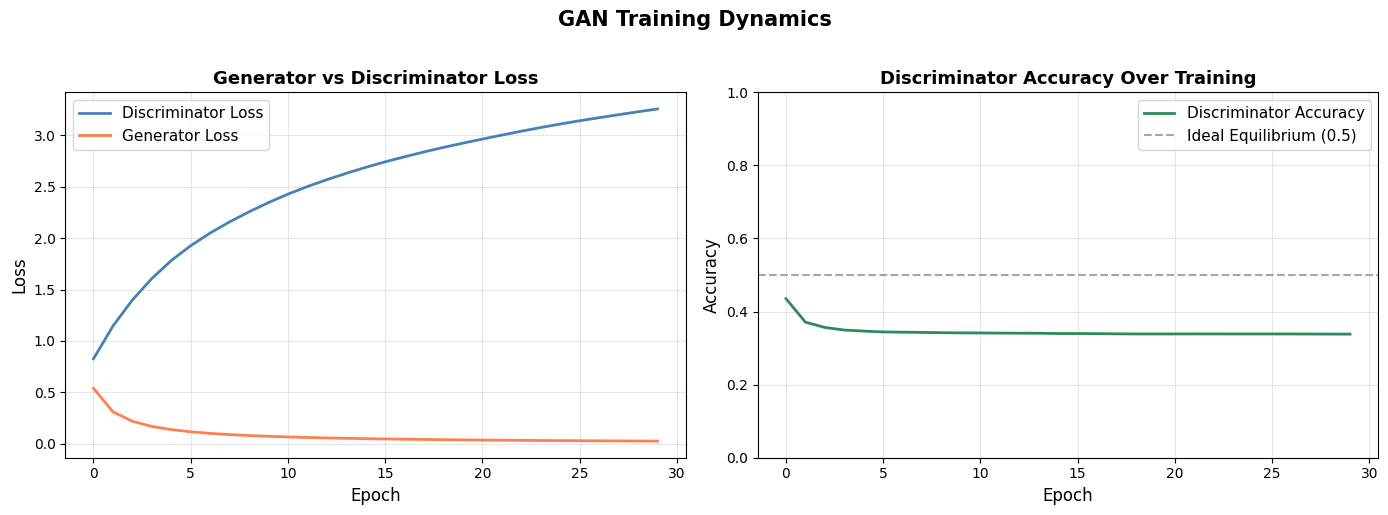

Final Discriminator Loss: 3.2566
Final Generator Loss: 0.0257
Final Discriminator Accuracy: 0.3383


In [9]:
# --- Training Loss History ---
print("=" * 60)
print("TRAINING LOSS HISTORY")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(range(EPOCHS), d_losses, label='Discriminator Loss', color='steelblue', linewidth=2)
axes[0].plot(range(EPOCHS), g_losses, label='Generator Loss', color='coral', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Generator vs Discriminator Loss', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Discriminator accuracy plot
axes[1].plot(range(EPOCHS), d_accuracies, label='Discriminator Accuracy', color='seagreen', linewidth=2)
axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Ideal Equilibrium (0.5)')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Discriminator Accuracy Over Training', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1])

plt.suptitle('GAN Training Dynamics', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"Final Discriminator Loss: {d_losses[-1]:.4f}")
print(f"Final Generator Loss: {g_losses[-1]:.4f}")
print(f"Final Discriminator Accuracy: {d_accuracies[-1]:.4f}")

GENERATED IMAGES (FINAL EPOCH)


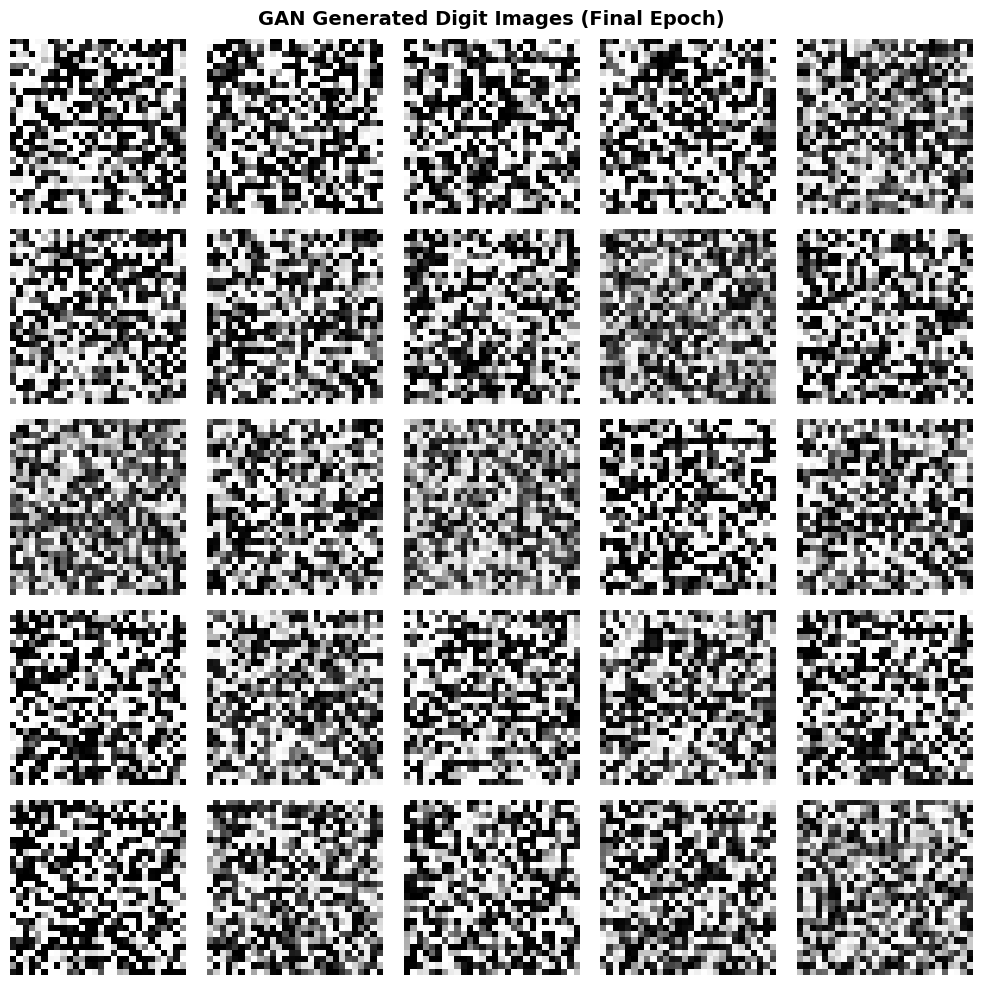

Generated 25 images from random noise vectors.
Image Shape: (28, 28, 1)
Pixel Range (raw): [-1.000, 1.000]


In [10]:
# --- Generated Images Visualization ---
print("=" * 60)
print("GENERATED IMAGES (FINAL EPOCH)")
print("=" * 60)

# Generate a 5x5 grid of images
noise = np.random.normal(0, 1, (25, LATENT_DIM))
generated_images = generator.predict(noise, verbose=0)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = generated_images[i].reshape(28, 28)
    # Rescale from [-1, 1] to [0, 1] for display
    img = 0.5 * img + 0.5
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.suptitle('GAN Generated Digit Images (Final Epoch)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Generated {len(generated_images)} images from random noise vectors.")
print(f"Image Shape: {generated_images[0].shape}")
print(f"Pixel Range (raw): [{generated_images.min():.3f}, {generated_images.max():.3f}]")

GENERATION QUALITY OVER TRAINING


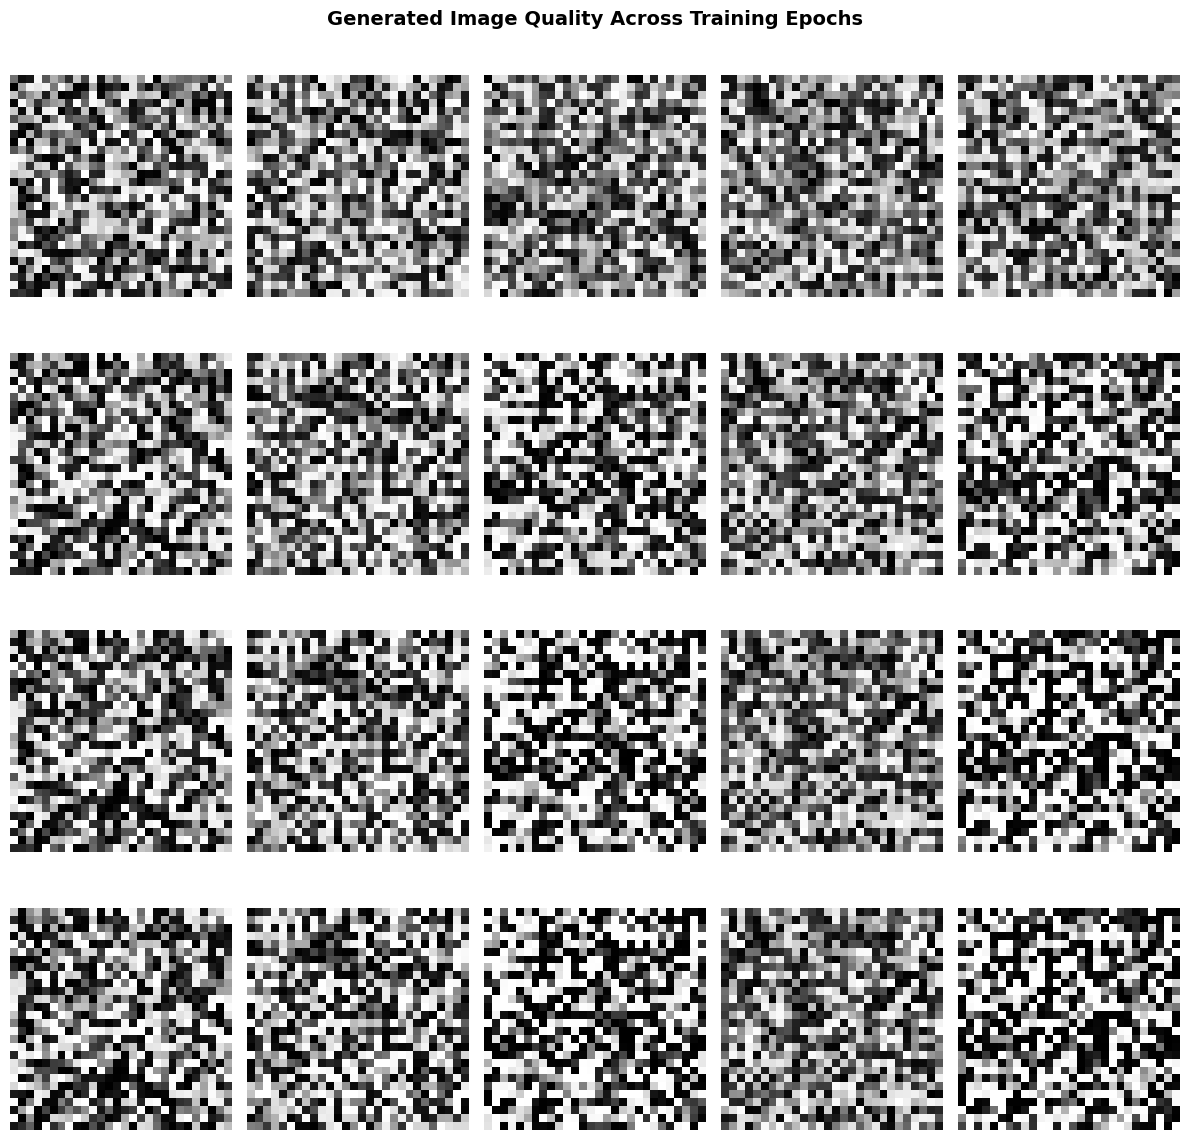

Saved epochs for comparison: [0, 10, 20, 29]
Notice how image quality improves as training progresses.


In [11]:
# --- Generation Quality Over Training ---
print("=" * 60)
print("GENERATION QUALITY OVER TRAINING")
print("=" * 60)

fig, axes = plt.subplots(len(saved_epochs), 5, figsize=(12, 3 * len(saved_epochs)))

for row, epoch in enumerate(saved_epochs):
    imgs = saved_images[epoch]
    for col in range(5):
        img = imgs[col].reshape(28, 28)
        img = 0.5 * img + 0.5  # Rescale to [0, 1]
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].axis('off')
        if col == 0:
            axes[row, col].set_ylabel(f"Epoch {epoch}", fontsize=12, fontweight='bold', rotation=0, labelpad=60)

plt.suptitle('Generated Image Quality Across Training Epochs', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Saved epochs for comparison:", saved_epochs)
print("Notice how image quality improves as training progresses.")

LATENT SPACE EXPLORATION


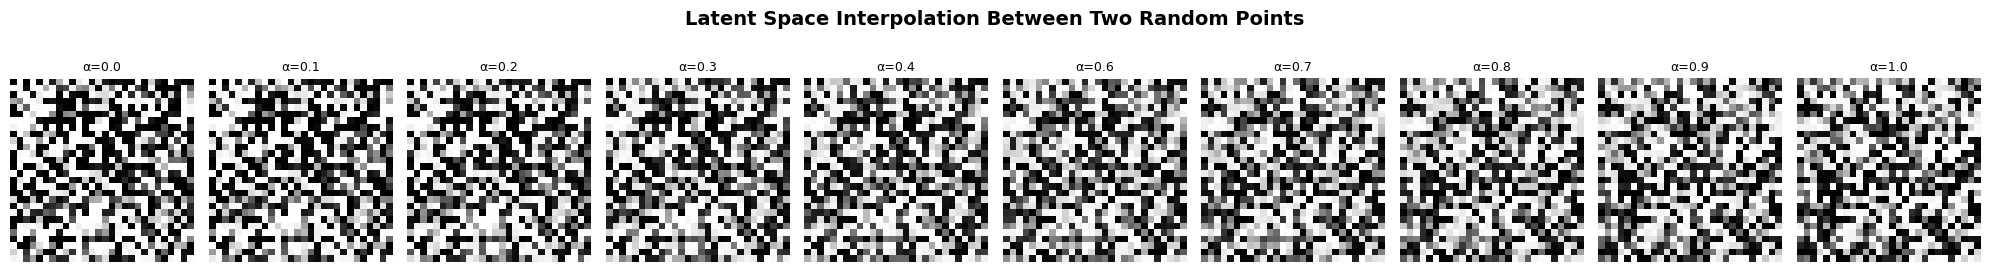

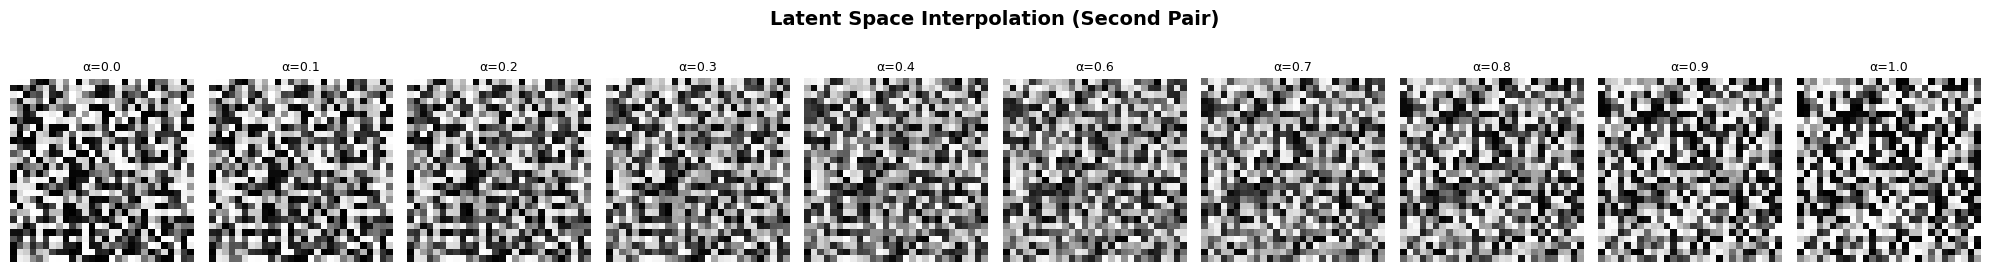

Smooth transitions between generated images indicate a well-structured latent space.
The generator has learned a continuous mapping from latent vectors to digit images.


In [12]:
# --- Latent Space Exploration (Interpolation) ---
print("=" * 60)
print("LATENT SPACE EXPLORATION")
print("=" * 60)

np.random.seed(99)
num_interpolations = 10

# Generate two random points in latent space
z1 = np.random.normal(0, 1, (1, LATENT_DIM))
z2 = np.random.normal(0, 1, (1, LATENT_DIM))

# Linear interpolation between z1 and z2
alphas = np.linspace(0, 1, num_interpolations)
interpolated = np.array([z1[0] * (1 - a) + z2[0] * a for a in alphas])

# Generate images from interpolated points
interpolated_images = generator.predict(interpolated, verbose=0)

fig, axes = plt.subplots(1, num_interpolations, figsize=(20, 3))
for i, ax in enumerate(axes):
    img = interpolated_images[i].reshape(28, 28)
    img = 0.5 * img + 0.5
    ax.imshow(img, cmap='gray')
    ax.set_title(f"\u03b1={alphas[i]:.1f}", fontsize=9)
    ax.axis('off')
plt.suptitle('Latent Space Interpolation Between Two Random Points', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Second interpolation pair
np.random.seed(123)
z3 = np.random.normal(0, 1, (1, LATENT_DIM))
z4 = np.random.normal(0, 1, (1, LATENT_DIM))
interpolated2 = np.array([z3[0] * (1 - a) + z4[0] * a for a in alphas])
interpolated_images2 = generator.predict(interpolated2, verbose=0)

fig, axes = plt.subplots(1, num_interpolations, figsize=(20, 3))
for i, ax in enumerate(axes):
    img = interpolated_images2[i].reshape(28, 28)
    img = 0.5 * img + 0.5
    ax.imshow(img, cmap='gray')
    ax.set_title(f"\u03b1={alphas[i]:.1f}", fontsize=9)
    ax.axis('off')
plt.suptitle('Latent Space Interpolation (Second Pair)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Smooth transitions between generated images indicate a well-structured latent space.")
print("The generator has learned a continuous mapping from latent vectors to digit images.")

In [13]:
# --- Final Summary ---
print("=" * 60)
print("EXPERIMENT SUMMARY")
print("=" * 60)
print(f"""
DATASET: MNIST Handwritten Digits
  - Training Subset: {TRAIN_SIZE} images
  - Image Size: 28 x 28 x 1
  - Normalization: [-1, 1]

GENERATOR ARCHITECTURE:
  - Input: Noise vector (dim={LATENT_DIM})
  - Dense(256) -> LeakyReLU(0.2) -> BatchNorm
  - Dense(512) -> LeakyReLU(0.2) -> BatchNorm
  - Dense(1024) -> LeakyReLU(0.2) -> BatchNorm
  - Dense(784, tanh) -> Reshape(28, 28, 1)
  - Parameters: {generator.count_params():,}

DISCRIMINATOR ARCHITECTURE:
  - Input: Image (28, 28, 1) -> Flatten
  - Dense(512) -> LeakyReLU(0.2) -> Dropout(0.3)
  - Dense(256) -> LeakyReLU(0.2) -> Dropout(0.3)
  - Dense(1, sigmoid)
  - Parameters: {discriminator.count_params():,}

TRAINING CONFIGURATION:
  - Epochs: {EPOCHS}
  - Batch Size: {BATCH_SIZE}
  - Optimizer: Adam (lr=0.0002, beta_1=0.5)
  - Loss: Binary Crossentropy

RESULTS:
  - Final D Loss: {d_losses[-1]:.4f}
  - Final G Loss: {g_losses[-1]:.4f}
  - Final D Accuracy: {d_accuracies[-1]:.4f}
""")


EXPERIMENT SUMMARY

DATASET: MNIST Handwritten Digits
  - Training Subset: 5000 images
  - Image Size: 28 x 28 x 1
  - Normalization: [-1, 1]

GENERATOR ARCHITECTURE:
  - Input: Noise vector (dim=100)
  - Dense(256) -> LeakyReLU(0.2) -> BatchNorm
  - Dense(512) -> LeakyReLU(0.2) -> BatchNorm
  - Dense(1024) -> LeakyReLU(0.2) -> BatchNorm
  - Dense(784, tanh) -> Reshape(28, 28, 1)
  - Parameters: 1,493,520

DISCRIMINATOR ARCHITECTURE:
  - Input: Image (28, 28, 1) -> Flatten
  - Dense(512) -> LeakyReLU(0.2) -> Dropout(0.3)
  - Dense(256) -> LeakyReLU(0.2) -> Dropout(0.3)
  - Dense(1, sigmoid)
  - Parameters: 533,505

TRAINING CONFIGURATION:
  - Epochs: 30
  - Batch Size: 128
  - Optimizer: Adam (lr=0.0002, beta_1=0.5)
  - Loss: Binary Crossentropy

RESULTS:
  - Final D Loss: 3.2566
  - Final G Loss: 0.0257
  - Final D Accuracy: 0.3383



# **Conclusion**

This experiment demonstrates **Generative Adversarial Networks (GANs)** — a powerful framework for generative modeling introduced by Goodfellow et al. (2014).

**Key Concepts:**
- A **Generator** learns to produce realistic images from random noise
- A **Discriminator** learns to distinguish real images from generated ones
- The two networks are trained in an **adversarial** setting — the generator improves by trying to fool the discriminator
- Training converges when the discriminator can no longer reliably distinguish real from fake (accuracy ≈ 0.5)

**Observations:**
- The generator progressively learns to produce digit-like images as training proceeds
- Latent space interpolation shows smooth transitions, indicating the model has learned meaningful representations
- Training dynamics (loss curves) reveal the adversarial interplay between generator and discriminator
- Using a small subset (5,000 images) and simple Dense layers makes training feasible on CPU

**Improvements for Better Results:**
- Use **DCGAN** (Deep Convolutional GAN) with Conv2D/Conv2DTranspose layers for sharper images
- Train on the full dataset with GPU acceleration
- Use techniques like **spectral normalization**, **label smoothing**, or **Wasserstein loss**
- Increase training epochs and model capacity
- Apply **conditional GAN** (cGAN) to generate specific digit classes

GANs are foundational to modern generative AI, powering applications in image synthesis, style transfer, data augmentation, super-resolution, and more.